In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Getting the observations for the selected stations

In [2]:
p = Path('../../data/ncdc')
observationsCSV = p.joinpath('observations_vlc.csv')
print ('Reading observations CSV')
dfObs = pd.read_csv(str(observationsCSV),index_col=0)
dfObs = dfObs[(dfObs.stn != 'stn')]
print ("{:,} observations".format(len(dfObs)))

Reading observations CSV
13,331 observations


In [3]:
dfObs.head()

,stn,wban,year,monthday,temp,temp_count,dewp,dewp_count,slp,slp_count,...,gust,max,max_flag,min,min_flag,prcp,prc_flag,sndp,frshtt,koppen
0,82840,99999,1991,101,52.5,24,46.5,24,9999.9,0,...,999.9,61.5,NaN,44.6,*,0.0,D,999.9,0,BSk
1,82840,99999,1991,102,47.7,24,40.9,24,9999.9,0,...,999.9,64.4,*,35.6,*,0.0,D,999.9,0,BSk
2,82840,99999,1991,103,47.0,24,40.0,24,9999.9,0,...,999.9,63.3,NaN,34.7,NaN,0.0,D,999.9,0,BSk
3,82840,99999,1991,104,48.5,24,37.0,24,9999.9,0,...,20.0,57.2,NaN,39.2,NaN,0.0,D,999.9,0,BSk
4,82840,99999,1991,105,47.0,24,34.2,24,9999.9,0,...,999.9,59.0,*,34.2,NaN,0.0,D,999.9,0,BSk


### Data management operations

Generate an index using the id station and the date

In [4]:
def getId(stn,wban):
    try:
        istn = int(stn)
        iwban = int(wban)
        return "{:0>6}-{:0>5}".format(istn,iwban)
    except ValueError:
        print("{}/{}".format(stn,wban))
        
def getStationByStnWban(stn,wban):
    try:
        koppen = scdfc.loc[getId(stn,wban)].koppen
    except KeyError:
        koppen = None
    return koppen   
def getDateTimeFromRow(row):
    try:
        iyear = int(row.year)
        imonth = int("{:0>4}".format(row.monthday)[0:2])
        iday = int("{:0>4}".format(row.monthday)[2:4])
        return  datetime(iyear,imonth,iday)
    except ValueError:
        return np.nan

dfObs['date'] = dfObs.apply(lambda row : getDateTimeFromRow(row),axis=1)
dfObs.set_index(['date'],inplace=True)

The `frshtt` column needs to be padded with zeros to get all the flags in the correct place. Then is possible to get the occurrence of different weather conditions

In [5]:
dfObs['frshtt']  = dfObs.apply(lambda row: "{:0>6}".format(row.frshtt),axis=1)
dfObs['fog']     = dfObs['frshtt'].apply(lambda row: row[0:1]=='1')
dfObs['rain']    = dfObs['frshtt'].apply(lambda row: row[1:2]=='1')
dfObs['snow']    = dfObs['frshtt'].apply(lambda row: row[2:3]=='1')
dfObs['hail']    = dfObs['frshtt'].apply(lambda row: row[3:4]=='1')
dfObs['thunder'] = dfObs['frshtt'].apply(lambda row: row[4:5]=='1')
dfObs['tornado'] = dfObs['frshtt'].apply(lambda row: row[5:6]=='1')

Recode the temperatures columns, replacing the NaN values and afterwards as numerics

In [6]:
dfObs['tempC'] = dfObs['temp'].replace('99.9', np.nan)
dfObs['maxC']  = dfObs['max'].replace('99.9', np.nan)
dfObs['minC']  = dfObs['min'].replace('99.9', np.nan)
dfObs['prcp']  = dfObs['min'].replace('99.99', np.nan)
dfObs['mxspd'] = dfObs['mxspd'].replace('999.9',np.nan)
dfObs['slp']   = dfObs['slp'].replace('9999.9',np.nan)

dfObs['tempC'] = pd.to_numeric(dfObs['tempC'])
dfObs['maxC']  = pd.to_numeric(dfObs['maxC'])
dfObs['minC']  = pd.to_numeric(dfObs['minC']) 
dfObs['prcp']  = pd.to_numeric(dfObs['prcp']) 
dfObs['mxspd'] = pd.to_numeric(dfObs['mxspd'])
dfObs['slp']   = pd.to_numeric(dfObs['slp'])
dfObs['visib'] = pd.to_numeric(dfObs['visib'])

def FtoC(f):
    return (f-32)*5/9

dfObs['tempC']= dfObs['tempC'].apply(lambda temp: FtoC(temp))
dfObs['maxC'] = dfObs['maxC'].apply(lambda temp: FtoC(temp))
dfObs['minC'] = dfObs['minC'].apply(lambda temp: FtoC(temp))

In [8]:
dfObs[['tempC','maxC','minC','prcp','mxspd','slp','visib']].describe()

,tempC,maxC,minC,prcp,mxspd,slp,visib
count,13331.000000,13330.000000,13331.000000,13331.000000,13317.000000,4779.000000,13331.000000
mean,17.114712,22.761665,12.062036,53.711665,13.966757,1017.453338,6.317035
std,6.023689,6.110861,6.213491,11.184284,6.173005,6.455067,1.689609
min,0.611111,5.000000,-6.000000,21.200000,1.900000,991.800000,0.100000
25%,12.166667,18.000000,7.000000,44.600000,9.900000,1013.200000,5.400000
50%,16.722222,22.611111,12.000000,53.600000,12.000000,1017.300000,6.400000
75%,22.555556,28.000000,17.611111,63.700000,15.900000,1021.500000,7.000000
max,31.277778,43.388889,26.388889,79.500000,55.900000,1038.800000,18.400000


In [9]:
print("Observations from {} to {}".format(dfObs.index.min().strftime("%d/%m/%y"),dfObs.index.max().strftime("%d/%m/%y")))

Observations from 01/01/73 to 08/07/09


## Univariate visualization

In [10]:
%matplotlib inline
df = dfObs.copy()

### Quantitative variables

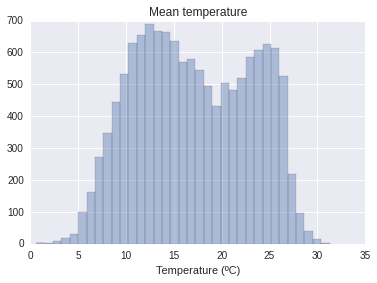

In [11]:
sns.distplot(df["tempC"].dropna(), kde=False);
plt.xlabel('Temperature (ºC)')
plt.title('Mean temperature')

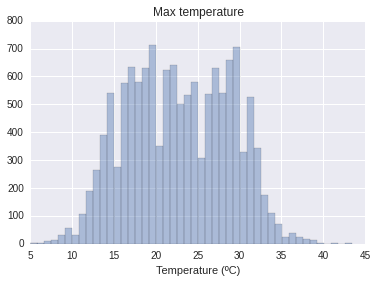

In [12]:
sns.distplot(df["maxC"].dropna(), kde=False);
plt.xlabel('Temperature (ºC)')
plt.title('Max temperature')

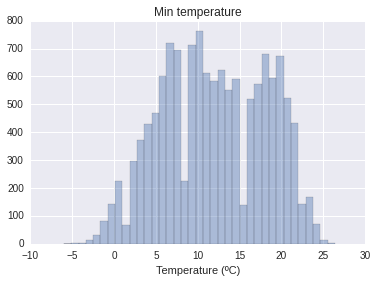

In [13]:
sns.distplot(df["minC"].dropna(), kde=False);
plt.xlabel('Temperature (ºC)')
plt.title('Min temperature')

Plotting the three variables together

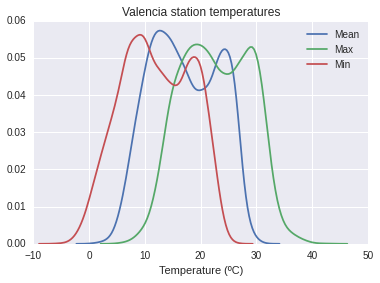

In [14]:
sns.kdeplot(df.tempC, label="Mean")
sns.kdeplot(df.maxC, label="Max")
sns.kdeplot(df.minC, label="Min")
plt.legend();
plt.xlabel('Temperature (ºC)')
plt.title('Valencia station temperatures')

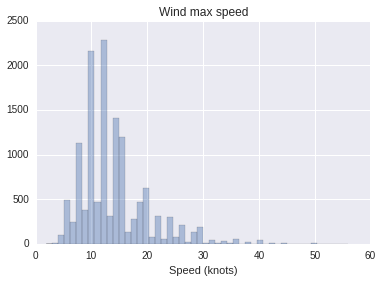

In [15]:
sns.distplot(dfObs.mxspd.dropna(),kde=False)
plt.xlabel('Speed (knots)')
plt.title(
    'Wind max speed')

### Qualitative variables

Our qualitative variables are all `True/False` so they are categorical by definition

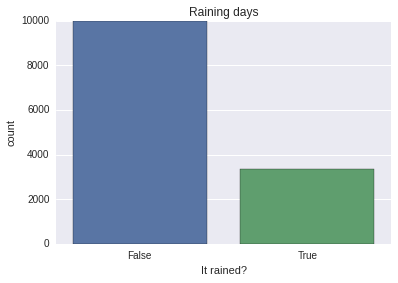

In [16]:
sns.countplot(x="rain", data=df);
plt.xlabel('It rained?')
plt.title('Raining days')

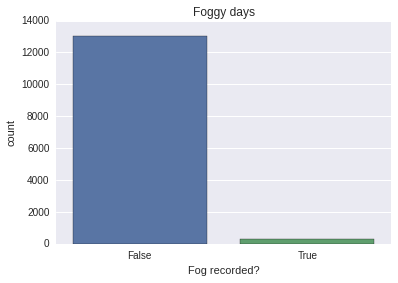

In [17]:
sns.countplot(x="fog", data=df);
plt.xlabel('Fog recorded?')
plt.title('Foggy days')

## Bivariate visualizations

Let's compare temperature and rainy days (quantitative to qualitative)

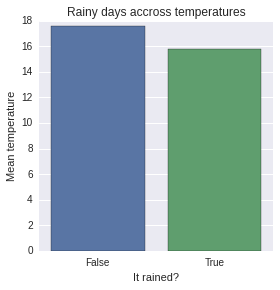

In [18]:
sns.factorplot(x="rain", y="tempC", data=df, kind="bar", ci=None)
plt.xlabel('It rained?')
plt.ylabel('Mean temperature')
plt.title('Rainy days accross temperatures')

What about pressure and rainy days?

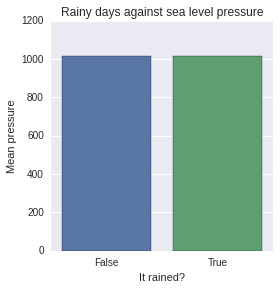

In [19]:
sns.factorplot(x="rain", y="slp", data=df, kind="bar", ci=None)
plt.xlabel('It rained?')
plt.ylabel('Mean pressure')
plt.title('Rainy days against sea level pressure')

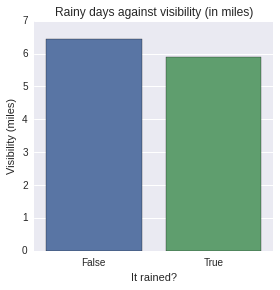

In [20]:
sns.factorplot(x="rain", y="visib", data=df, kind="bar", ci=None)
plt.xlabel('It rained?')
plt.ylabel('Visibility (miles)')
plt.title('Rainy days against visibility (in miles)')

Let's compare sea level presure and temperatures using a scatter plot

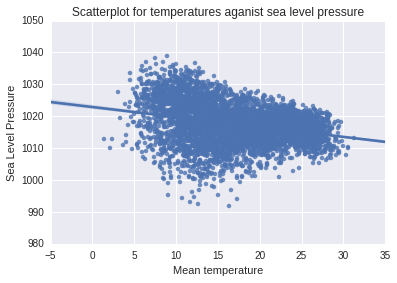

In [21]:
sns.regplot(x="tempC", y="slp", data=df)
plt.xlabel('Mean temperature')
plt.ylabel('Sea Level Pressure')
plt.title('Scatterplot for temperatures aganist sea level pressure')

What about using the measured precipitations?

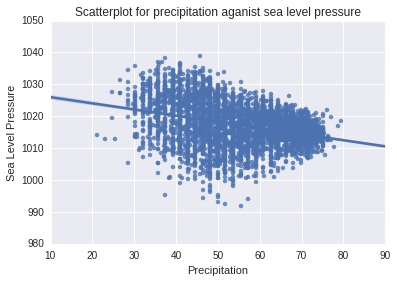

In [22]:
sns.regplot(x="prcp", y="slp", data=df)
plt.xlabel('Precipitation')
plt.ylabel('Sea Level Pressure')
plt.title('Scatterplot for precipitation aganist sea level pressure')

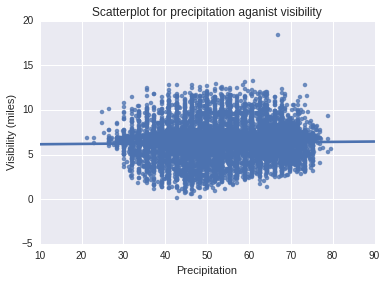

In [23]:
sns.regplot(x="prcp", y="visib", data=df)
plt.xlabel('Precipitation')
plt.ylabel('Visibility (miles)')
plt.title('Scatterplot for precipitation aganist visibility')

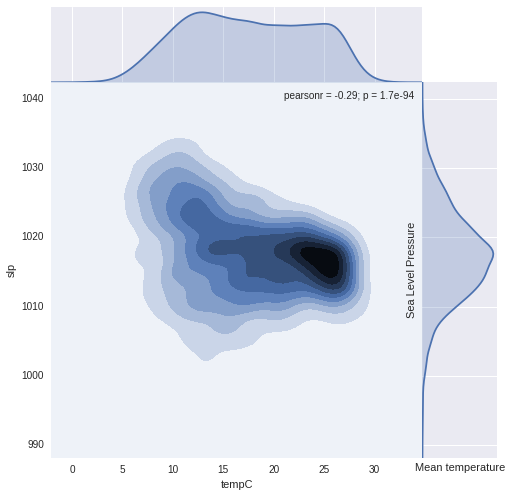

In [24]:
sns.jointplot(df.tempC, df.slp, kind="kde", size=7, space=0)
plt.xlabel('Mean temperature')
plt.ylabel('Sea Level Pressure')